In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
#from sklearn import preprocessing as pre
#from scipy.stats import zscore
from scipy import signal
from math import floor
from skimage.transform import resize

In [2]:
# function that resizes the signal to a desired shape
def df_resample(df1, num=1):
    df2 = pd.DataFrame()
    for key, value in df1.iteritems(): 
        temp = value.to_numpy()/value.abs().max() # normalize
        resampled = resize(temp, (num,1), mode='edge')*value.abs().max() # de-normalize
        df2[key] = resampled.flatten().round(5)
    return df2

In [3]:
path, dirs, files = next(os.walk("./Data/")) #path to primary activities
path2, dirs2, files2 = next(os.walk("./Data2/")) #path to secondary activities
nod1=len(dirs) #number of folders inside the first path
nod2=len(dirs2) #number of folders inside the second path
nod=nod1+nod2 #number of all classes

0
./Data/Left_Crossing
100
Directory already exists.


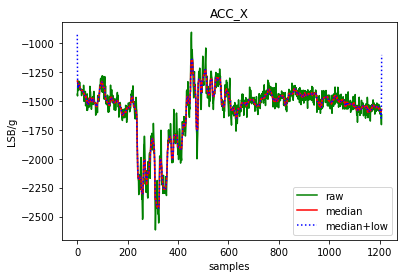

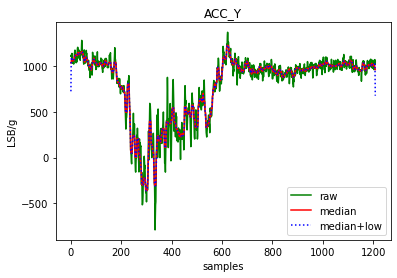

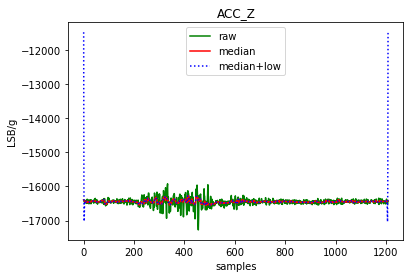

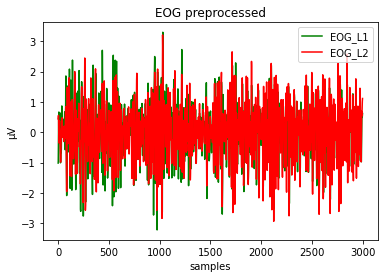

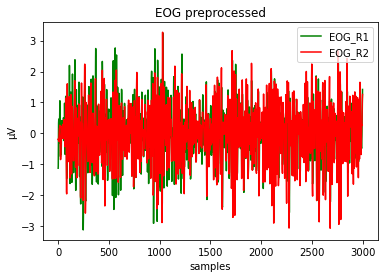

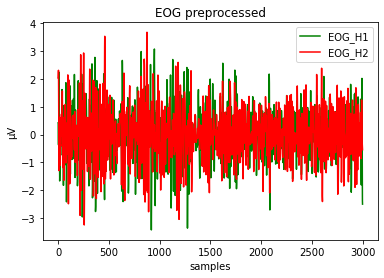

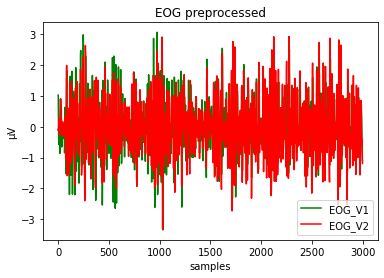

In [8]:
# create empty list
dataframes_list = list()
labels_list = list()
cut=0.04 # for cutting off the edges

#reading the data from appropriate folders
for j in range(1):#(nod):
    if j<nod1:
        c_path=os.path.join(path, dirs[j])
        print(j)
        print(c_path)
        c_path, c_dirs, c_files = next(os.walk(c_path))
        file_count = len(c_files)
        print(file_count)
        new_path=os.path.join('./Data_preprocessed1/', dirs[j])
    else:
        c_path=os.path.join(path2, dirs2[j-nod1])
        print(j)
        print(c_path)
        c_path, c_dirs, c_files = next(os.walk(c_path))
        file_count = len(c_files)
        print(file_count)
        new_path=os.path.join('./Data_preprocessed1/', dirs2[j-nod1])
    try: 
        os.mkdir(new_path) 
    except OSError as error: 
        print("Directory already exists.")
    
      
    # append datasets to the list
    for i in range(1):#(file_count):
        temp_df = pd.read_csv(c_path + '/' + c_files[i], skiprows=6,
                              names=["NUM", "DATE", "ACC_X", "ACC_Y", "ACC_Z", "EOG_L1", "EOG_R1", "EOG_L2", "EOG_R2", "EOG_H1", "EOG_H2", "EOG_V1", "EOG_V2"])
        temp_df= temp_df.drop(['NUM','DATE'],axis=1)
        temp_df = temp_df.astype(float)
              
        
        data=temp_df.iloc[:,:3].to_numpy() #ACC data
        fs=50 #sampling frequency
        cutoff=20
        median_data=median_filter(data, 11)
        comb_data=freq_filter(median_data, 11, cutoff/fs)

        plots_ACC(temp_df, median_data, comb_data)
### plots        
#        plt.figure()
#
#        plt.plot(temp_df.iloc[:,0].to_numpy(), '-g', label='raw')
#        plt.plot(median_data[:,0], '-r', label='median')
#        plt.plot(comb_data[:,0], ':b', label='median+low')
#        plt.title('ACC_X')
#        
#       plt.xlabel('samples')
#        plt.ylabel('LSB/g')
#        plt.legend()
#        
#        plt.figure()
#
#        plt.plot(temp_df.iloc[:,1].to_numpy(), '-g', label='raw')
#        plt.plot(median_data[:,1], '-r', label='median')
#        plt.plot(comb_data[:,1], ':b', label='median+low')
#        plt.title('ACC_Y')
#        
#        plt.xlabel('samples')
#        plt.ylabel('LSB/g')
#        plt.legend()
#        
#        plt.figure()
#
#        plt.plot(temp_df.iloc[:,2].to_numpy(), '-g', label='raw')
#        plt.plot(median_data[:,2], '-r', label='median')
#        plt.plot(comb_data[:,2], ':b', label='median+low')
#        plt.title('ACC_Z')
#        
#        plt.xlabel('samples')
#        plt.ylabel('LSB/g')
#        plt.legend()
        
        
        comb_data = comb_data[floor(cut*len(temp_df)):(len(temp_df)-floor(cut*len(temp_df))) , :] #cutting off the edges

        #normalization
        comb_data[:,0] = [(v - np.mean(comb_data[:,0]))/np.std(comb_data[:,0]) for v in comb_data[:,0]]
        comb_data[:,1] = [(v - np.mean(comb_data[:,1]))/np.std(comb_data[:,1]) for v in comb_data[:,1]]
        comb_data[:,2] = [(v - np.mean(comb_data[:,2]))/np.std(comb_data[:,2]) for v in comb_data[:,2]]
        
        tf=pd.DataFrame(comb_data) #into a dataframe
        tf = df_resample(tf, 3000) #resampling 

# Process it
        
        # for EOG signal    
        for k in range(3, len(temp_df.columns)):
            b, a = signal.butter(2, 1 - (200 - 100)/200) #filtering
            y = signal.filtfilt(b, a, temp_df.iloc[:,k])

            temp_df.iloc[:,k]=pd.DataFrame(y).diff() # baseline drift removal
            temp_df.iloc[:,k] = [(v - (temp_df.iloc[:,k].mean()))/temp_df.iloc[:,k].std() for v in temp_df.iloc[:,k]] #normalization

        temp_df.dropna(inplace=True)
        temp_df=pd.DataFrame(temp_df.iloc[floor(cut*len(temp_df)):(len(temp_df)-floor(cut*len(temp_df))) , :])
        temp_df = df_resample(temp_df, 3000)

        plots_EOG(temp_df)
#### plots
#        plt.figure()
#        plt.plot(temp_df.iloc[:,3]. to_numpy(), '-g', label='EOG_L1')
#        plt.plot(temp_df.iloc[:,5]. to_numpy(), '-r', label='EOG_L2')
#        
#        plt.title('EOG preprocessed')
#
#        plt.xlabel('samples')
#        plt.ylabel(u'\u03bc' 'V')
#        plt.legend() 
#        
#        plt.figure()
#       plt.plot(temp_df.iloc[:,4]. to_numpy(), '-g', label='EOG_R1')
#        plt.plot(temp_df.iloc[:,6]. to_numpy(), '-r', label='EOG_R2')
#        
#        plt.title('EOG preprocessed')
#
#        plt.xlabel('samples')
#        plt.ylabel(u'\u03bc' 'V')
#        plt.legend() 
#        
#       plt.figure()
#        plt.plot(temp_df.iloc[:,7]. to_numpy(), '-g', label='EOG_H1')
#        plt.plot(temp_df.iloc[:,8]. to_numpy(), '-r', label='EOG_H2')
#        
#        plt.title('EOG preprocessed')
#
#        plt.xlabel('samples')
#        plt.ylabel(u'\u03bc' 'V')
#        plt.legend() 
#        
#        plt.figure()
#        plt.plot(temp_df.iloc[:,9]. to_numpy(), '-g', label='EOG_V1')
#        plt.plot(temp_df.iloc[:,10]. to_numpy(), '-r', label='EOG_V2')
#        
#        plt.title('EOG preprocessed')
#
#        plt.xlabel('samples')
#        plt.ylabel(u'\u03bc' 'V')
#        plt.legend() 
            

        temp_df.iloc[:,:3]=tf.iloc[:]
# Plot
            #nk.eog_plot(signals, info, sampling_rate=100)
    
        
        #temp_df.to_csv(new_path +'/'+ c_files[i]) # saving the preprocessed signals into a csv file in a specified path

In [4]:
#plots ACC

def plots_ACC(temp_df, median_data, comb_data):
    plt.figure()

    plt.plot(temp_df.iloc[:,0].to_numpy(), '-g', label='raw')
    plt.plot(median_data[:,0], '-r', label='median')
    plt.plot(comb_data[:,0], ':b', label='median+low')
    plt.title('ACC_X')
        
    plt.xlabel('samples')
    plt.ylabel('LSB/g')
    plt.legend()
        
    plt.figure()

    plt.plot(temp_df.iloc[:,1].to_numpy(), '-g', label='raw')
    plt.plot(median_data[:,1], '-r', label='median')
    plt.plot(comb_data[:,1], ':b', label='median+low')
    plt.title('ACC_Y')
        
    plt.xlabel('samples')
    plt.ylabel('LSB/g')
    plt.legend()
        
    plt.figure()

    plt.plot(temp_df.iloc[:,2].to_numpy(), '-g', label='raw')
    plt.plot(median_data[:,2], '-r', label='median')
    plt.plot(comb_data[:,2], ':b', label='median+low')
    plt.title('ACC_Z')
        
    plt.xlabel('samples')
    plt.ylabel('LSB/g')
    plt.legend()

In [5]:
#plots EOG 
def plots_EOG(temp_df):
    plt.figure()
    plt.plot(temp_df.iloc[:,3]. to_numpy(), '-g', label='EOG_L1')
    plt.plot(temp_df.iloc[:,5]. to_numpy(), '-r', label='EOG_L2')
        
    plt.title('EOG preprocessed')

    plt.xlabel('samples')
    plt.ylabel(u'\u03bc' 'V')
    plt.legend() 
        
    plt.figure()
    plt.plot(temp_df.iloc[:,4]. to_numpy(), '-g', label='EOG_R1')
    plt.plot(temp_df.iloc[:,6]. to_numpy(), '-r', label='EOG_R2')
        
    plt.title('EOG preprocessed')

    plt.xlabel('samples')
    plt.ylabel(u'\u03bc' 'V')
    plt.legend() 
        
    plt.figure()
    plt.plot(temp_df.iloc[:,7]. to_numpy(), '-g', label='EOG_H1')
    plt.plot(temp_df.iloc[:,8]. to_numpy(), '-r', label='EOG_H2')
        
    plt.title('EOG preprocessed')

    plt.xlabel('samples')
    plt.ylabel(u'\u03bc' 'V')
    plt.legend() 
        
    plt.figure()
    plt.plot(temp_df.iloc[:,9]. to_numpy(), '-g', label='EOG_V1')
    plt.plot(temp_df.iloc[:,10]. to_numpy(), '-r', label='EOG_V2')
       
    plt.title('EOG preprocessed')

    plt.xlabel('samples')
    plt.ylabel(u'\u03bc' 'V')
    plt.legend() 

In [6]:
#filtering accelerometer data

def median_filter(data, f_size):
    lgth, num_signal=data.shape
    f_data=np.zeros([lgth, num_signal])
    for i in range(num_signal):
        f_data[:,i]=signal.medfilt(data[:,i], f_size)
    return f_data

def freq_filter(data, f_size, cutoff):
    lgth, num_signal=data.shape
    f_data=np.zeros([lgth, num_signal])
    lpf=signal.firwin(f_size, cutoff, window='hamming')
    for i in range(num_signal):
        f_data[:,i]=signal.convolve(data[:,i], lpf, mode='same')
    return f_data